# **Trabajo N°3: Analitica Predictiva y Prescritiva**
**Thiare Guerrero - Sebastián Celedón**

### **1. Librerias**

In [38]:
# Scikit-learn
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, log_loss)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Utilidades
import graphviz
import pandas as pd
import numpy as np
import ast
import joblib
from difflib import get_close_matches

###**2. Cargar y explorar el dataset**

Se carga un conjunto de datos desde un archivo CSV ubicado en la ruta especificada (file_path) utilizando la librería pandas. Luego, se proporciona un resumen básico del contenido del dataset: muestra su estructura general, incluyendo el tipo de datos de cada columna y la cantidad de valores no nulos, seguido de una vista previa de las primeras filas del dataset para dar una idea inicial de los datos disponibles.

In [2]:
# Cargar el dataset
file_path = '/content/data.csv'
data = pd.read_csv(file_path)

# Mostrar información básica del dataset
print("Estructura del dataset:")
print(data.info())
print("\nPrimeras filas del dataset:")
print(data.head())

Estructura del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4237 entries, 0 to 4236
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Nombre                     4237 non-null   object 
 1   Precio                     4237 non-null   float64
 2   Fecha de Lanzamiento       4237 non-null   object 
 3   Plataformas                4237 non-null   object 
 4   Total de Reseñas           4237 non-null   int64  
 5   Porcentaje de Positividad  4237 non-null   int64  
 6   Generos                    4237 non-null   object 
 7   Éxito                      4237 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 264.9+ KB
None

Primeras filas del dataset:
                                 Nombre  Precio Fecha de Lanzamiento  \
0                      Counter-Strike 2    0.00         Aug 21, 2012   
1  S.T.A.L.K.E.R. 2: Heart of Chornobyl   59.99         Nov 20, 2024

**Definicion variable exito**
se define una función llamada evaluar_exito_reajustado, que asigna un valor binario (1 o 0) a cada juego según dos criterios: el total de reseñas y el porcentaje de positividad de las reseñas.

La función clasifica el juego en **4 categorías** según estas métricas:

1. Éxito masivo (1): Si el juego tiene más de 100,000 reseñas y un porcentaje de positividad de al menos 85%.
2. Éxito alto (1): Si el juego tiene más de 50,000 reseñas y un porcentaje de positividad superior al 90%.
3. Moderadamente exitoso (1): Si el juego tiene más de 10,000 reseñas y un porcentaje de positividad superior al 85%.
4. No exitoso (0): Si no cumple con ninguno de los criterios anteriores.


In [3]:
# Ajustar el criterio de éxito para considerar juegos populares
def evaluar_exito_reajustado(row):
    if row['Total de Reseñas'] > 100000 and row['Porcentaje de Positividad'] >= 85:
        return 1  # Éxito masivo
    elif row['Total de Reseñas'] > 50000 and row['Porcentaje de Positividad'] > 90:
        return 1  # Éxito alto
    elif row['Total de Reseñas'] > 10000 and row['Porcentaje de Positividad'] > 85:
        return 1  # Moderadamente exitoso
    else:
        return 0  # No exitoso

data['Éxito Reajustado'] = data.apply(evaluar_exito_reajustado, axis=1)


### **3. Manipulación de datos para el modelo**

En esta etapa del código, primero se seleccionan las **variables predictoras** y la **variable objetivo**. Las variables predictoras (X) incluyen información como el **precio**, el **total de reseñas**, el **porcentaje de positividad**, las **plataformas** en las que está disponible el juego y sus **géneros**. La **variable objetivo** (y_reajustado) es la columna que indica si un juego es exitoso o no, basada en los criterios previamente definidos en la función "evaluar_exito_reajustado".

Luego, se lleva a cabo el **preprocesamiento de los datos**. Las variables se dividen en dos grupos: las características **categóricas** (como **plataformas** y **géneros**) y las **numéricas** (como **precio**, **total de reseñas** y **porcentaje de positividad**). A continuación, se usa un "ColumnTransformer" para aplicar transformaciones específicas: las características numéricas se estandarizan utilizando el "StandardScaler" para asegurar que todas tengan la misma escala, mientras que las características categóricas se codifican mediante "OneHotEncoder", que convierte las categorías en variables binarias, y se establece el parámetro "handle_unknown='ignore'" para manejar cualquier valor desconocido en las plataformas o géneros.

Finalmente, los datos se **dividen en conjuntos de entrenamiento y prueba** utilizando la función "train_test_split". El 80% de los datos se asigna al conjunto de entrenamiento y el 20% restante al conjunto de prueba. Se usa el parámetro "stratify" para asegurar que la distribución de la variable objetivo en ambos conjuntos sea proporcional. Después de la división, se imprimen los tamaños de los conjuntos de entrenamiento y prueba para verificar que la partición se haya realizado correctamente.



In [4]:
# Preparar las variables predictoras y objetivo
X = data[['Precio', 'Total de Reseñas', 'Porcentaje de Positividad', 'Plataformas', 'Generos']]
y_reajustado = data['Éxito Reajustado']

# Preprocesar los datos
categorical_features = ['Plataformas', 'Generos']
numerical_features = ['Precio', 'Total de Reseñas', 'Porcentaje de Positividad']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y_reajustado, test_size=0.2, random_state=42, stratify=y_reajustado
)
train_size = X_train.shape[0]
test_size = X_test.shape[0]
print(f"Datos de entrenamiento: {train_size}")
print(f"Datos de prueba: {test_size}")

Datos de entrenamiento: 3389
Datos de prueba: 848


### **4. Creacion del modelo random forest**

In [5]:
# Crear el modelo ajustado con hiperparámetros modificados
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_estimators=200,         # Incremento del número de árboles
        max_depth=20,             # Ajuste de la profundidad máxima
        min_samples_leaf=2,       # Permitir hojas más pequeñas
        min_samples_split=6       # Más divisiones en los nodos
    ))
])

# Entrenar el modelo
model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred_test = model.predict(X_test)

# Calcular y mostrar resultados del modelo
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)

print("Accuracy del modelo:", round(test_accuracy * 100, 2), "%")

print("\nReporte de Clasificación:")
print(class_report)


Accuracy del modelo: 98.94 %

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       687
           1       1.00      0.94      0.97       161

    accuracy                           0.99       848
   macro avg       0.99      0.97      0.98       848
weighted avg       0.99      0.99      0.99       848



In [6]:
# Obtener los nombres de las características transformadas
feature_names = numerical_features + list(
    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
)

# Extraer un árbol individual del RandomForest
single_tree = model.named_steps['classifier'].estimators_[0]

# Exportar el árbol a un archivo DOT
export_graphviz(single_tree, out_file="tree.dot",
                feature_names=feature_names,  # Nombres correctos de las caracteristicas
                class_names=["No Exitoso", "Exitoso"],
                filled=True, rounded=True,
                special_characters=True)

# Convertir el archivo DOT a un gráfico PDF
!dot -Tpdf tree.dot -o tree_visualization.pdf

print("El árbol ha sido guardado como 'tree_visualization.pdf'")


El árbol ha sido guardado como 'tree_visualization.pdf'


In [7]:
# Guardar el modelo entrenado
joblib.dump(model, 'modelofinal.pkl')

print("Modelo guardado como 'modelofinal.pkl'")

Modelo guardado como 'modelofinal.pkl'


### **5. Validacion y metricas del modelo**

In [8]:
# Validación cruzada para evaluar consistencia
cross_val_scores = cross_val_score(model, X_train, y_train, cv=5)

# Mostrar los resultados finales
print("Accuracy en el conjunto de prueba:", round(test_accuracy * 100, 2), "%")
print("Promedio de validación cruzada:", round(cross_val_scores.mean() * 100, 2), "%")
print("Desviación estándar en validación cruzada:", round(cross_val_scores.std() * 100, 2), "%")

# Analizar las características más importantes
def obtener_importancia_caracteristicas(model, preprocessor):
    importances = model.named_steps['classifier'].feature_importances_
    feature_names = numerical_features + list(
        preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    )
    return pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

feature_importance_df = obtener_importancia_caracteristicas(model, preprocessor)
print("\nCaracterísticas más importantes:")
print(feature_importance_df.head(10))


Accuracy en el conjunto de prueba: 98.94 %
Promedio de validación cruzada: 98.64 %
Desviación estándar en validación cruzada: 1.18 %

Características más importantes:
                                       Feature  Importance
1                             Total de Reseñas    0.604261
2                    Porcentaje de Positividad    0.242687
0                                       Precio    0.041043
6                      Plataformas_['Windows']    0.014613
4      Plataformas_['Windows', 'Mac', 'Linux']    0.010494
210                         Generos_Action,RPG    0.003909
8                     Generos_Action,Adventure    0.003505
7                               Generos_Action    0.003328
5               Plataformas_['Windows', 'Mac']    0.003156
73   Generos_Action,Adventure,Indie,Simulation    0.003074


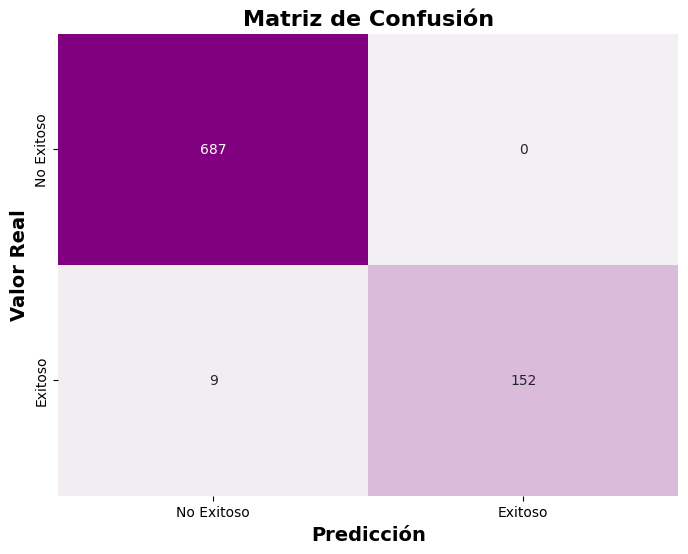

In [9]:
def graficar_matriz_confusion(conf_matrix, clases):
    # Crear una paleta pastel con más tonos
    pastel_cmap = sns.light_palette("purple", as_cmap=True)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=pastel_cmap, xticklabels=clases, yticklabels=clases, cbar=False)
    plt.xlabel('Predicción', fontsize=14, fontweight='bold')
    plt.ylabel('Valor Real', fontsize=14, fontweight='bold')
    plt.title('Matriz de Confusión', fontsize=16, fontweight='bold')
    plt.show()

clases = ['No Exitoso', 'Exitoso']
graficar_matriz_confusion(conf_matrix, clases)


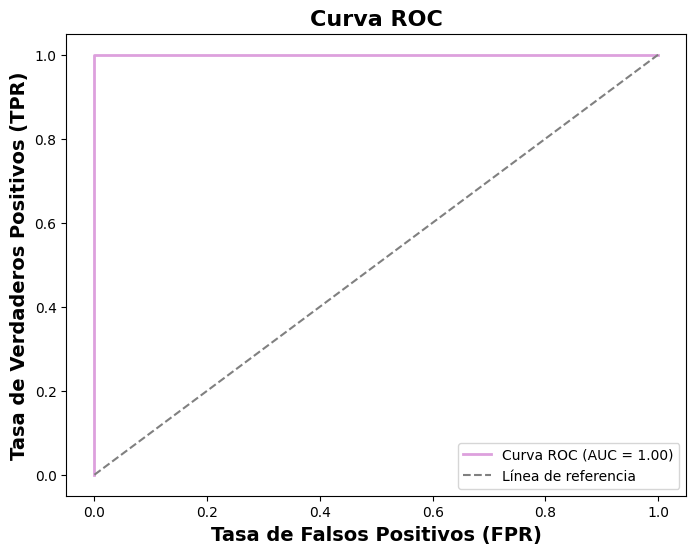

In [10]:
# Generar curva ROC
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="#DDA0DD", linewidth=2, label='Curva ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Línea de referencia')
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=14, fontweight='bold')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=14, fontweight='bold')
plt.title('Curva ROC', fontsize=16, fontweight='bold')
plt.legend(loc='lower right')
plt.show()

Puntuaciones por fold: [100.    99.71 100.    99.71  97.64  97.64  99.12  99.71  97.94  99.7 ]
Promedio de validación cruzada: 99.11 %
Desviación estándar: 0.93 %


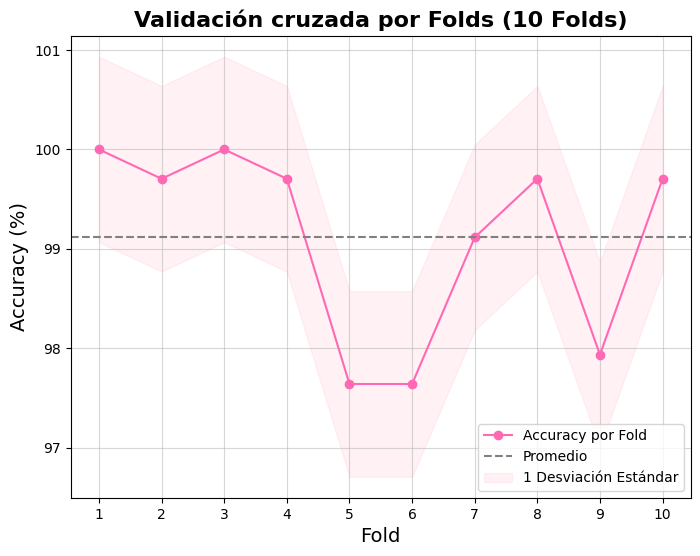

In [11]:
# Configurar 10 folds para validación cruzada
cv_10folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Calcular las puntuaciones de validación cruzada con 10 folds
cv_10_scores = cross_val_score(model, X_train, y_train, cv=cv_10folds, scoring='accuracy')

# Resultados por fold
print("Puntuaciones por fold:", np.round(cv_10_scores * 100, 2))
print("Promedio de validación cruzada:", round(np.mean(cv_10_scores) * 100, 2), "%")
print("Desviación estándar:", round(np.std(cv_10_scores) * 100, 2), "%")

# Graficar resultados de validación cruzada con 10 folds
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_10_scores) + 1), cv_10_scores * 100, marker='o', color='#FF69B4', label='Accuracy por Fold')
plt.axhline(np.mean(cv_10_scores) * 100, color='gray', linestyle='--', label='Promedio')
plt.fill_between(range(1, len(cv_10_scores) + 1),
                 (cv_10_scores - np.std(cv_10_scores)) * 100,
                 (cv_10_scores + np.std(cv_10_scores)) * 100,
                 color='#FFD1DC', alpha=0.3, label='1 Desviación Estándar')
plt.title('Validación cruzada por Folds (10 Folds)', fontsize=16, fontweight='bold')
plt.xlabel('Fold', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(range(1, len(cv_10_scores) + 1))
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()


Log Loss del modelo: 0.184


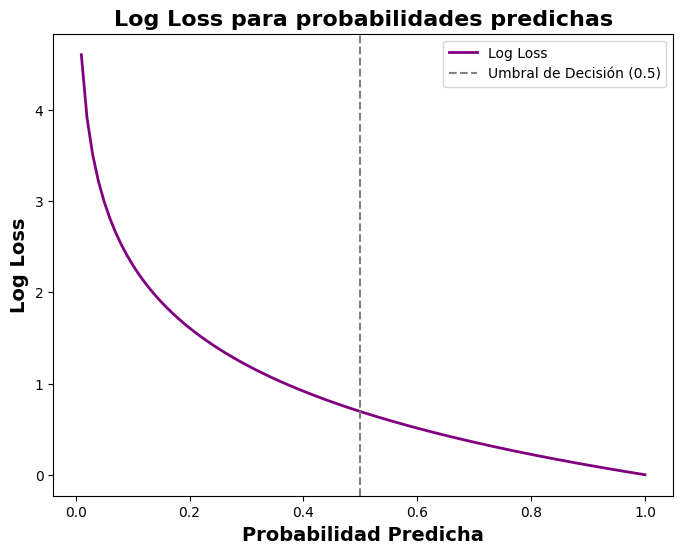

In [12]:
# Obtener probabilidades de predicción para el conjunto de prueba
y_pred_proba = model.predict_proba(X_test)

# Calcular Log Loss
log_loss_value = log_loss(y_test, y_pred_proba)

print("Log Loss del modelo:", round(log_loss_value, 4))

# Crear datos de ejemplo para Log Loss
probabilidades = np.linspace(0.01, 1, 100)
log_loss_values = -np.log(probabilidades)

# Graficar Log Loss
plt.figure(figsize=(8, 6))
plt.plot(probabilidades, log_loss_values, color="purple", label='Log Loss', linewidth=2)
plt.axvline(0.5, color='gray', linestyle='--', label='Umbral de Decisión (0.5)')
plt.xlabel('Probabilidad Predicha', fontsize=14, fontweight='bold')
plt.ylabel('Log Loss', fontsize=14, fontweight='bold')
plt.title('Log Loss para probabilidades predichas', fontsize=16, fontweight='bold')
plt.legend(loc='upper right')
plt.show()

### **6. Pruebas para comprobar overffiting**

In [13]:
# Evaluar el modelo en el conjunto de entrenamiento
y_pred_train = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Evaluar el modelo en el conjunto de prueba
y_pred_test = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Comparar las precisiones
print("Accuracy en el conjunto de entrenamiento:", round(train_accuracy * 100, 2), "%")
print("Accuracy en el conjunto de prueba:", round(test_accuracy * 100, 2), "%")

# Calcular la diferencia entre entrenamiento y prueba
overfitting_gap = round(train_accuracy * 100, 2) - round(test_accuracy * 100, 2)
overfitting_gap_truncated = int(overfitting_gap * 100) / 100
print("Diferencia entre el conjunto de entrenamiento y prueba (Overfitting Gap):", overfitting_gap_truncated,"%")


Accuracy en el conjunto de entrenamiento: 99.35 %
Accuracy en el conjunto de prueba: 98.94 %
Diferencia entre el conjunto de entrenamiento y prueba (Overfitting Gap): 0.4 %


In [14]:
# Validación cruzada para evaluar consistencia
cross_val_scores = cross_val_score(model, X_train, y_train, cv=5)

# Mostrar los resultados finales
print("Accuracy en el conjunto de prueba:", round(test_accuracy * 100, 2), "%")
print("Promedio de validación cruzada:", round(cross_val_scores.mean() * 100, 2), "%")
print("Desviación estándar en validación cruzada:", round(cross_val_scores.std() * 100, 2), "%")

# Analizar las características más importantes
def obtener_importancia_caracteristicas(model, preprocessor):
    importances = model.named_steps['classifier'].feature_importances_
    feature_names = numerical_features + list(
        preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    )
    return pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

feature_importance_df = obtener_importancia_caracteristicas(model, preprocessor)
print("\nCaracterísticas más importantes:")
print(feature_importance_df.head(10))


Accuracy en el conjunto de prueba: 98.94 %
Promedio de validación cruzada: 98.64 %
Desviación estándar en validación cruzada: 1.18 %

Características más importantes:
                                       Feature  Importance
1                             Total de Reseñas    0.604261
2                    Porcentaje de Positividad    0.242687
0                                       Precio    0.041043
6                      Plataformas_['Windows']    0.014613
4      Plataformas_['Windows', 'Mac', 'Linux']    0.010494
210                         Generos_Action,RPG    0.003909
8                     Generos_Action,Adventure    0.003505
7                               Generos_Action    0.003328
5               Plataformas_['Windows', 'Mac']    0.003156
73   Generos_Action,Adventure,Indie,Simulation    0.003074


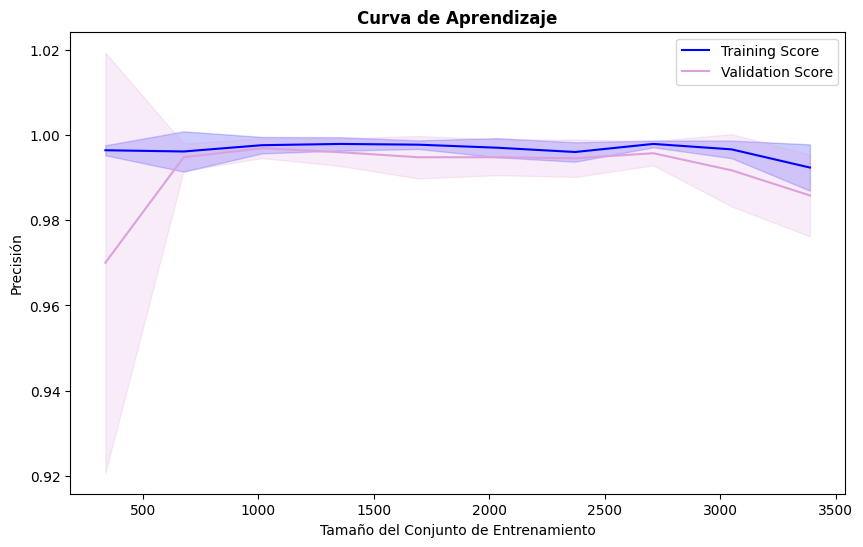

In [15]:
# Calcular curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y_reajustado, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Promedio y desviación estándar de los resultados
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.plot(train_sizes, test_mean, label="Validation Score", color="#DDA0DD")

# Sombrear la desviación estándar
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDA0DD", alpha=0.2)

plt.title("Curva de Aprendizaje", fontweight='bold')
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Precisión")
plt.legend(loc="best")
plt.show()


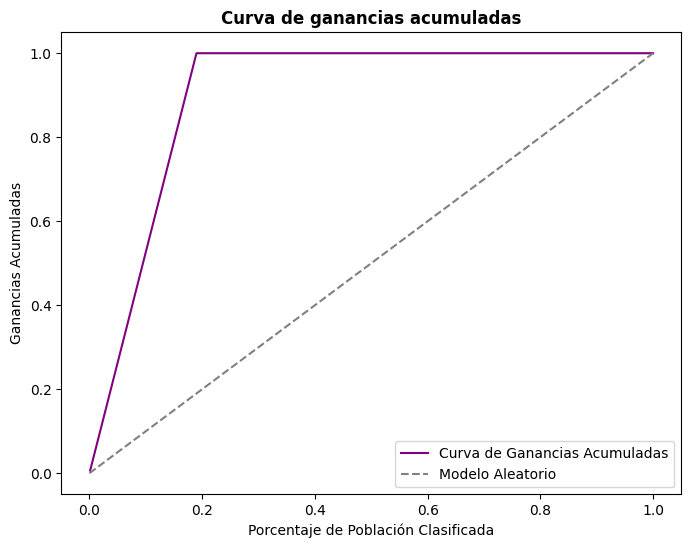

In [16]:
# Calcular las probabilidades predichas para la clase positiva
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Ordenar las observaciones por probabilidad predicha
sorted_indices = np.argsort(y_pred_proba)[::-1]
sorted_y_test = np.array(y_test)[sorted_indices]

# Calcular ganancias acumuladas
cumulative_gains = np.cumsum(sorted_y_test) / np.sum(sorted_y_test)

# Generar el eje x (porcentaje de observaciones)
percentage_of_population = np.arange(1, len(cumulative_gains) + 1) / len(cumulative_gains)

# Graficar la curva de ganancias acumuladas
plt.figure(figsize=(8, 6))
plt.plot(percentage_of_population, cumulative_gains, label="Curva de Ganancias Acumuladas", color="purple")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Modelo Aleatorio")
plt.xlabel('Porcentaje de Población Clasificada')
plt.ylabel('Ganancias Acumuladas')
plt.title('Curva de ganancias acumuladas',fontweight='bold')
plt.legend(loc="lower right")
plt.show()


### **7. Analisis prescriptivo**

In [17]:
# Analizar los mejores juegos según las predicciones
data['Predicción Reajustada'] = model.predict(X)
juegos_exitosos_reajustados = data[data['Predicción Reajustada'] == 1][
    ['Nombre', 'Total de Reseñas', 'Porcentaje de Positividad', 'Generos']
]

juegos_exitosos_reajustados = juegos_exitosos_reajustados.sort_values(
    by=['Total de Reseñas', 'Porcentaje de Positividad'], ascending=[False, False]
)

print("\nTop 20 juegos exitosos según el modelo reajustado:")
print(juegos_exitosos_reajustados.head(20))



Top 20 juegos exitosos según el modelo reajustado:
                        Nombre  Total de Reseñas  Porcentaje de Positividad  \
29          Grand Theft Auto V           1742850                         87   
128                   Terraria           1073361                         97   
176                Garry's Mod            955973                         96   
10                        Rust            933215                         87   
43          Black Myth: Wukong            733743                         96   
314   The Witcher 3: Wild Hunt            733501                         96   
30                  ELDEN RING            717457                         92   
208              Left 4 Dead 2            684482                         97   
55              Stardew Valley            665944                         98   
334     Euro Truck Simulator 2            610661                         97   
6              Baldur's Gate 3            598544                         96   


In [18]:
# Analizar los juegos menos exitosos según las predicciones
data['Predicción Reajustada'] = model.predict(X)

# Filtrar los juegos menos exitosos (Predicción Reajustada == 0)
juegos_menos_exitosos_reajustados = data[data['Predicción Reajustada'] == 0][
    ['Nombre', 'Total de Reseñas', 'Porcentaje de Positividad','Generos']
]

# Ordenar los juegos menos exitosos por 'Total de Reseñas' y 'Porcentaje de Positividad'
juegos_menos_exitosos_reajustados = juegos_menos_exitosos_reajustados.sort_values(
    by=['Total de Reseñas', 'Porcentaje de Positividad'], ascending=[False, False]
)

# Mostrar los 10 juegos menos exitosos según el modelo reajustado
print("\nTop 20 juegos menos exitosos según el modelo reajustado:")
print(juegos_menos_exitosos_reajustados.head(20))



Top 20 juegos menos exitosos según el modelo reajustado:
                              Nombre  Total de Reseñas  \
40               PUBG: BATTLEGROUNDS           2464167   
0                   Counter-Strike 2           2436198   
23                            Dota 2           2361992   
41   Tom Clancy's Rainbow Six® Siege           1131515   
58                   Team Fortress 2           1125189   
20                     Apex Legends™            964390   
38                    Cyberpunk 2077            694083   
13                     HELLDIVERS™ 2            674414   
15                         Destiny 2            615572   
248                         Among Us            608818   
3                           Warframe            599017   
7                        War Thunder            561899   
16                  Dead by Daylight            547022   
185            ARK: Survival Evolved            532471   
222                       Brawlhalla            376119   
22            

In [29]:
# Generar la columna 'Predicción Reajustada'
data['Predicción Reajustada'] = model.predict(X)

# Filtrar los juegos exitosos según la predicción del modelo
juegos_exitosos = data[data['Predicción Reajustada'] == 1]

# Convertir las plataformas de string con '[]' a listas reales usando ast.literal_eval()
juegos_exitosos['Plataformas'] = juegos_exitosos['Plataformas'].apply(ast.literal_eval)

# Separar las plataformas por juego (expandir las listas en filas)
plataformas_separadas = juegos_exitosos['Plataformas'].explode().reset_index(drop=True)

# Contar la cantidad de juegos exitosos por plataforma
conteo_plataformas = plataformas_separadas.value_counts().reset_index()
conteo_plataformas.columns = ['Plataforma', 'Número de Juegos Exitosos']

# Crear gráfico interactivo con un color único para todas las barras
fig = px.bar(conteo_plataformas, x='Plataforma', y='Número de Juegos Exitosos',
             title='Frecuencia de Plataformas Exitosas Según el Modelo',
             labels={'Plataforma': 'Plataforma', 'Número de Juegos Exitosos': 'Número de Juegos Exitosos'},
             color_discrete_sequence=['#D5006D'],  # Tono único para todas las barras
             template='plotly', opacity=0.8)

# Añadir los valores sobre las barras
fig.update_traces(text=conteo_plataformas['Número de Juegos Exitosos'], textposition='outside')

# Personalizar el tamaño del gráfico para ajustarlo
fig.update_layout(
    width=800,  # Ajustar el ancho
    height=600  # Ajustar la altura si es necesario
)

# Mostrar el gráfico interactivo
fig.show()


<ipython-input-29-6dc35a3086b9>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
# Paso 1: Realizar predicciones de éxito
data['Predicción_Éxito'] = model.predict(X)

# Filtrar los juegos predichos como exitosos
juegos_exitosos = data[data['Predicción_Éxito'] == 1]

# Paso 2: Limpiar y separar géneros
def limpiar_generos(generos):
    """
    Limpia y separa los géneros, independientemente del formato.
    """
    if pd.isna(generos):  # Manejar valores nulos
        return []
    generos = generos.strip()  # Quitar espacios innecesarios
    if generos.startswith('"') and generos.endswith('"'):  # Detectar géneros con comillas
        generos = generos[1:-1]  # Remover las comillas externas
    return [g.strip() for g in generos.split(',')]  # Separar por comas y limpiar espacios

# Aplicar la función de limpieza
juegos_exitosos['Generos'] = juegos_exitosos['Generos'].apply(limpiar_generos)

# Expandir los géneros en filas individuales
juegos_exitosos_exploded = juegos_exitosos.explode('Generos')

# Paso 3: Contar la frecuencia de géneros individuales
generos_exitosos = juegos_exitosos_exploded['Generos'].value_counts().reset_index()
generos_exitosos.columns = ['Genero', 'Cantidad de Juegos']

# Ordenar por cantidad de juegos exitosos descendente
generos_exitosos = generos_exitosos.sort_values(by='Cantidad de Juegos', ascending=False)
# Crear el gráfico interactivo con Plotly
fig = px.bar(
    generos_exitosos,
    x='Cantidad de Juegos',
    y='Genero',
    orientation='h',  # Orientación horizontal
    title='Géneros con mayor probabilidad de éxito ',
    labels={'Cantidad de juegos': 'Cantidad de Juegos Exitosos', 'Genero': 'Género'},
    text='Cantidad de Juegos'  # Mostrar valores en las barras
)

# Personalizar el diseño
fig.update_traces(marker_color='pink', textposition='outside')  # Cambiar color y posición del texto
fig.update_layout(
    xaxis_title='Cantidad de juegos éxitosos',
    yaxis_title='Género',
    yaxis=dict(categoryorder='total ascending'),  # Ordenar de menor a mayor en el eje Y
    template='plotly_white',  # Estilo del gráfico
    title_font=dict(size=20, family='Arial'),
    width=800,
    height=600
)

# Mostrar el gráfico interactivo
fig.show()


<ipython-input-30-40b52e18500a>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
# Función para buscar coincidencias y determinar el éxito de un juego
def buscar_videojuego(videojuego_ingresado, data):
    # Normalizar el nombre ingresado (ignorar mayúsculas/minúsculas)
    videojuego_ingresado = videojuego_ingresado.lower()

    # Obtener los nombres de los videojuegos en el dataset, en formato minúscula
    nombres_juegos = data['Nombre'].str.lower().tolist()

    # Buscar nombres similares (aumentar cutoff para mayor similitud)
    coincidencias = get_close_matches(videojuego_ingresado, nombres_juegos, n=5, cutoff=0.7)

    if coincidencias:
        print("\nSe encontraron las siguientes coincidencias similares:")
        for i, nombre in enumerate(coincidencias):
            print(f"{i + 1}. {data[data['Nombre'].str.lower() == nombre]['Nombre'].values[0]}")

        # Pedir al usuario que elija una opción
        seleccion = input("\nElige el número correspondiente al videojuego que deseas consultar\n (o escribe 'salir' para terminar): ")

        if seleccion.lower() == 'salir':
            return "Interacción terminada."

        if seleccion.isdigit():
            seleccion = int(seleccion)
            if 1 <= seleccion <= len(coincidencias):
                # Obtener el videojuego seleccionado
                nombre_seleccionado = coincidencias[seleccion - 1]
                fila = data[data['Nombre'].str.lower() == nombre_seleccionado]

                # Determinar si es exitoso o no
                if fila['Predicción Reajustada'].values[0] == 1:
                    return f"El videojuego '{fila['Nombre'].values[0]}' es exitoso según el modelo.\n------------------------------------------"
                else:
                    return f"El videojuego '{fila['Nombre'].values[0]}' no es exitoso según el modelo.\n------------------------------------------"
            else:
                return "Número de opción inválido."
        else:
            return "Entrada inválida. Por favor, ingresa un número."
    else:
        return "No se encontraron juegos similares en el dataset. Intenta con otro nombre."

# Probar la interacción
while True:
    entrada = input("\nIngresa el nombre de un videojuego (o escribe 'salir' para terminar):\n ")
    if entrada.lower() == 'salir':
        print("Interacción terminada.")
        break
    resultado = buscar_videojuego(entrada, data)
    print(resultado)



Ingresa el nombre de un videojuego (o escribe 'salir' para terminar):
 Star Wars: Battlefront

Se encontraron las siguientes coincidencias similares:
1. STAR WARS™ Battlefront
2. STAR WARS™ Battlefront (Classic, 2004)

Elige el número correspondiente al videojuego que deseas consultar
 (o escribe 'salir' para terminar): 2
El videojuego 'STAR WARS™ Battlefront (Classic, 2004)' no es exitoso según el modelo.
------------------------------------------

Ingresa el nombre de un videojuego (o escribe 'salir' para terminar):
 Star Wars: Battlefront

Se encontraron las siguientes coincidencias similares:
1. STAR WARS™ Battlefront
2. STAR WARS™ Battlefront (Classic, 2004)

Elige el número correspondiente al videojuego que deseas consultar
 (o escribe 'salir' para terminar): 1
El videojuego 'STAR WARS™ Battlefront' no es exitoso según el modelo.
------------------------------------------

Ingresa el nombre de un videojuego (o escribe 'salir' para terminar):
 Star Wars: Battlefront 2

Se encontr